# Reinforcement Learning
*Reinforcement Learning (RL)* is can be thought of as a mix of supervised and unsupervised learning or a strange variant of self-supervised learning which has the following setup:
* There is an *agent* that tries to (rationally) act in an *environment*
* Taking an *action* might have a stochastic effect (typically stationary) and results in an *observation* of the *state* the environment is in
* Each state transiition yield certain reward (or conversly has a cost) and the goal of a rational RL agent is to learn a *policy* that maximizes expected (discounted) gain in the long run

Of course this is quite standard description arising from a model of *Markov Decision Processes (MDPs)* (more on this later) but there are many variants of it that depend on:
* Whether the agent acts rationally - taking action that maximizes expected utility
* If there is just partial observability of the states - leads to *Partially Observable Markov Decision Processes (POMDPs)*
* Whether is the environment stationary or not - leads to adversarial variants of RL or to *Game Theory* (agent's actions depend on actions of other actors)
* What are other statistical propertis of the rewards and state transitions? - e.g. if the reward depends on action or state or both; whether the policy depends only on the current state or (partial) history of taken actions

In [1]:
# FIXME: meke autocompletion working again
%config Completer.use_jedi = False

import os

# OpenAI gym
import gym

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import tensorflow as tf

# Get smooth animations
mpl.rc('animation', html='jshtml')

physical_devices = tf.config.list_physical_devices('GPU')

if not physical_devices:
    print("No GPU was detected.")
else:
    # https://stackoverflow.com/a/60699372
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
from tensorflow import keras

No GPU was detected.


## Introduction to OpenAI gym

In [2]:
# List first few environments
list(gym.envs.registry.all())[:10]

[EnvSpec(Copy-v0),
 EnvSpec(RepeatCopy-v0),
 EnvSpec(ReversedAddition-v0),
 EnvSpec(ReversedAddition3-v0),
 EnvSpec(DuplicatedInput-v0),
 EnvSpec(Reverse-v0),
 EnvSpec(CartPole-v0),
 EnvSpec(CartPole-v1),
 EnvSpec(MountainCar-v0),
 EnvSpec(MountainCarContinuous-v0)]

In [3]:
# Make the CartPole (v1) environment
env = gym.make('CartPole-v1')

# Initialize the environment
#  - Note that `reset` returns the initial state/observation
env.seed(42)
obs = env.reset()

# An obesrvation in the CartPole environment consists of
#  1. cart's horizontal position
#  2. its velocity
#  3. the angle of the pole (0 = vertical)
#  4. the angular velocity
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

In [4]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [5]:
# Render the environment and return an image as a numpy array
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

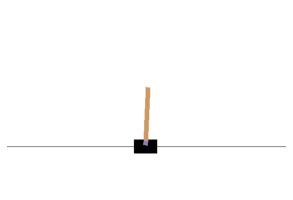

In [6]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img


plot_environment(env)
plt.show()

In [7]:
# Get available actions
env.action_space

Discrete(2)

In [8]:
# Accelerate right
action = 1

# Make single interaction with the environment
obs, reward, done, info = env.step(action)

obs

array([-0.01261699,  0.19292789,  0.04204097, -0.28092127])

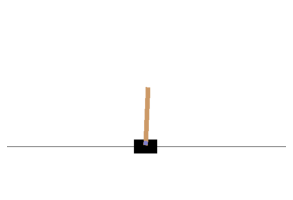

In [9]:
plot_environment(env)
plt.show()

In this environment the agent always receives a reward of 1. I.e. the goal is to play as long as possible (until `done == True`) - make the *episode* as long as possible.

In [10]:
reward

1.0

There is no info in this case but in general it can contain additional useful information such as number of lives or HP in a game.

In [11]:
info

{}

In [12]:
# One should always reset the enviroment after an episode
if done:
    obs = env.reset()

## A simple hard-coded policy

In [13]:
# Reset RNG state
env.seed(42)


def basic_policy(obs):
    """
    Naive policy that turns the cart left or right depending on 
    the direction current angle.
    """
    angle = obs[2]
    return 0 if angle < 0 else 1


def run_episode(env, policy, n_steps):
    """
    Execute single episode with given policy and 
    return accumulated reward.
    """
    episode_rewards = 0
    obs = env.reset()
    for step in range(n_steps):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            return episode_rewards
    return episode_rewards


# Hyperparameters
n_episodes = 500
n_steps = 200

# Collect total rewards from all episodes
totals = [run_episode(env, basic_policy, n_steps) for _ in range(n_episodes)]

# Show statistics of episodic rewards
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.718, 8.858356280936096, 24.0, 68.0)

This naive policy was able to keep the pole up for maximum of 68 episodes (reward 1 per episode => total reward is also the number of steps until done).

In [14]:
# Reset RNG state
env.seed(42)


def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,


def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis("off")
    anim = animation.FuncAnimation(
        fig,
        update_scene,
        fargs=(frames, patch),
        frames=len(frames),
        repeat=repeat,
        interval=interval,
    )
    plt.close()
    return anim
    

# Run single episode to collect all frames
frames = []
obs = env.reset()
for _ in range(n_steps):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)
    obs, _, done, _ = env.step(action)
    if done:
        break
        
# Visualize the episode
plot_animation(frames)

## Neural Network Policies
Let's replace the hard-coded policy by one represented by a (deep) neural network. We start by creating the model in which
* Inputs will be currenty observed state of the environment
* Outputs will a probablity distribution over actions

*Note: There are just two actions in our simple CartPole environment so we need only one output unit for one probability prob(left), then prob(right) = 1 - prob(left).*

In [15]:
# Reset TF session and set RNG state
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


def render_policy_net(model, n_max_steps=200, seed=42):
    
    # Create and seed CartPole environment
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    
    # Initialize the environment
    obs = env.reset()
    
    # Run an episode using the model
    for _ in range(n_max_steps):
        
        # Generate a frame representing its current state
        yield env.render(mode="rgb_array")
        
        # Feed the observation to the model to get the policy it represents
        left_proba = model.predict(obs.reshape(1, -1))
        
        # Sample action from the stochastic policy represented by the model
        action = int(np.random.rand() > left_proba)
        
        # Apply the action in the environment
        obs, _, done, _ = env.step(action)
        if done:
            break
    
    env.close()

    
# An observation for the CartPole is 4D
n_inputs = env.observation_space.shape[0]

# Build simple model
model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

# Show an animation of single episode using the model
frames = list(render_policy_net(model))
plot_animation(frames)

Let's now train the model. We will do so on multiple environments in parallel which should give us a diverse training batch at each step. We implement it using custom training loop in order to be able to use the predictions to advance the environments during each iteration. Finally, instead of using a greedy policy (applying an action yielding maximum reward), we sample an action at random given learned probabilities to include exploration factor in.

In [16]:
# Hyperparameters
n_environments = 50
n_iterations = 5000
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

# Make bunch of CartPole environments to train the model on
envs = [gym.make("CartPole-v1") for _ in range(n_environments)]

# Set RNG states
for i, env in enumerate(envs):
    env.seed(i)

np.random.seed(42)

# Initialize all environments
observations = [env.reset() for env in envs]

# Run custom training loop
for i in range(n_iterations):
    
    # Generate target action probability distribution
    #  - if angle < 0, we want proba(left) = 1 
    #  - else proba(left) = 0
    target_probas = np.array([
        ([1.] if obs[2] < 0 else [0.])
        for obs in observations
    ])
    
    # Feed the observation input to the model and compute mean loss
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    
    print("\rIteration: {}, Loss: {:.3f}".format(i, loss.numpy()), end="")
    
    # Backpropagate gradients using recorder forward feed
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # Sample an action from the learned probability distribution
    #  - Note: Learning a stochastic policy includes an implicit explorations
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    
    # Make one step in each environment
    #  - If current episode ends in an environment, it is reset
    for env_ix, env in enumerate(envs):
        obs, _, done, _ = env.step(actions[env_ix][0])
        observations[env_ix] = obs if not done else env.reset()


# Shutdown all environments
for env in envs:
    env.close()


# Show an animation of sinle episode using the model
frames = list(render_policy_net(model))
plot_animation(frames)

Iteration: 4999, Loss: 0.094

## Policy Gradients
The problem with learning target action probabilities is that taking an action usually has delayed effect - i.e. in a short term an action might look good but it is actually bad in the long run (or vice versa). This is called a *credit assignment problem*.

The **Policy Gradients** algorithm tackles this problem by first playing multiple episodes, then making the actions in good episodes slightly more likely, while actions in bad episodes are made slightly less likely. First we play, then we go back and think about what we did.

In [17]:
# Reset TF session and RNG state
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
    

def play_one_step(env, obs, model, loss_fn):
    
    # Make and record a forward pass through the model
    with tf.GradientTape() as tape:
        
        # Feed current state to the model to get action probabilities
        #  - For the CartPole environment this is just prob(left)
        action_distribution = model(obs[np.newaxis])
        
        # Sample an action to play given action distributions
        #  - Note: this ensures certain level of exploration
        action = (tf.random.uniform([1, 1]) > action_distribution)
        
        # Determine the target probability and compute current loss
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, action_distribution))
    
    # Compute gradients of the loss function recorded during the forward pass
    grads = tape.gradient(loss, model.trainable_variables)
    
    # Apply the action in the environment and return new state, reward and loss gradients
    obs, reward, done, _ = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads


def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    rewards = []
    gradients = []
    
    for _ in range(n_episodes):
        
        # Initialize new episode
        episode_rewards = []
        episode_gradients = []
        obs = env.reset()
        
        # Run multiple steps in current episode and record rewards and loss gradients
        for _ in range(n_max_steps):
            obs, reward, done, step_gradients = play_one_step(env, obs, model, loss_fn)
            
            episode_rewards.append(reward)
            episode_gradients.append(step_gradients)
            
            if done:
                break
                
        # Save rewards and gradients from current episode
        rewards.append(episode_rewards)
        gradients.append(episode_gradients)
    
    return rewards, gradients


def discount_rewards(rewards, discount_rate):
    """
    Compute cumulative discounted rewards using given discount rate.
    
    >>> discount_rewards([10, 0, -50], discount_rate=0.8)
    array([-22, -40, -50])
    """
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted


def discount_and_normalize_rewards(episodic_rewards, discount_rate):
    """
    Discount rewards from each episode and scale them using overall mean and std.
    
    >>> discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)
    [array([-0.28435071, -0.86597718, -1.18910299]),
     array([1.26665318, 1.0727777 ])]
    """
    # Discount rewards from each episode
    discounted_rewards = [
        discount_rewards(rewards, discount_rate)
        for rewards in episodic_rewards
    ]
    
    # Flatten episodic rewards and compute overall mean and std
    all_rewards = np.concatenate(discounted_rewards)
    reward_mean = all_rewards.mean()
    reward_std = all_rewards.std()
        
    # Scale (normalize) episodic rewards
    return [(rewards - reward_mean) / reward_std for rewards in discounted_rewards]
            

def mean_weighted_gradients(param, rewards, gradients):
    """
    Weight gradients (of given model parameter) with immediate rewards of respective episodic step.
    Returns mean of weighted gradients over all episodes.
    """
    
    weighted_gradients = [
        reward * gradients[episode][step][param]
        for episode, episode_rewards in enumerate(rewards)
        for step, reward in enumerate(episode_rewards)
    ]
    
    return tf.reduce_mean(weighted_gradients, axis=0)


# Hyperparameters
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

# Define the model
model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

n_params = len(model.trainable_variables)

# Create the CartPole environment
env = gym.make("CartPole-v1")
env.seed(42);


# Run custom training loop implementing Policy Gradient algorithm
for i in range(n_iterations):
    
    # Use current model to play couple of episodes (mini-batch)
    #  - The idea is to use current policy (represented by the model) to sample the environment well enough
    #  - During this "sampling" we record both immediate rewards and gradients of the loss function
    rewards, gradients = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
    
    # Display how well current model does in the environment
    mean_rewards = sum(map(sum, rewards)) / n_episodes_per_update
    print(f"\rIteration: {i}, mean rewards: {mean_rewards:.1f}", end="")
    
    # Discount future rewards in each episode and normalize by overall mean and std
    norm_rewards = discount_and_normalize_rewards(rewards, discount_rate)
    
    # Compute mean weighted gradients over all trial episodes
    #  - We weight each gradient by respective norm. reward (for that particular episode and step)
    mean_gradients = [mean_weighted_gradients(param, norm_rewards, gradients) for param in range(n_params)]
        
    # Make one SGD step with the mean gradients
    optimizer.apply_gradients(zip(mean_gradients, model.trainable_variables))

# Shutdown the environment
env.close()

# Visualize learned policy
frames = list(render_policy_net(model))
plot_animation(frames)

Iteration: 149, mean rewards: 197.6

## Markov Chains
*Markov Chains (MC)* is a simple model of a stochastic process defined over a set of states by a matrix of transition probabilities between states. Given this matrix and an initial state (or a prior distribution over these states) one can develop a chain of state transitions.

In [18]:
# Set RNG state
np.random.seed(42)

# Shape is [s, s'], i.e. current to next state
transition_probabilities = [
    [0.7, 0.2, 0.0, 0.1],
    [0.0, 0.0, 0.9, 0.1],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0],
]

n_states = len(transition_probabilities)
initial_state = 0
terminal_state = 3
n_max_steps = 50


def print_sequence(state=0):
    """Walk the chain from given initial state"""
    
    print("States:", end=" ")
    
    for step in range(n_max_steps):
        print(state, end=" ")
        
        # Stop if in terminal state
        if state == terminal_state:
            break
            
        # Sample next state given the transition model for current state
        state = np.random.choice(range(n_states), p=transition_probabilities[state])
    
    else:
        print("...", end="")
        
    print()


# Explore the model multiple times
for _ in range(10):
    print_sequence(state=initial_state)

States: 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 3 
States: 0 0 0 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


## Markov Decision Process
*Markov Decision Process (MDP)* is an extension of MC in which there are not only states by also actions applicable in each state (chosen by an RL agent). Furthermore, the  trainsition probabilities are conditioned not only by current state but the action as well - i.e. the transition model is $T(s, a, s') = Pr(s'|a, s)$, that is the probability of reaching state $s'$ when taking action $a$ in state $s$. Finally, there is a reward $R(s, a, s')$ attached to each transition and the goal of our RL agent is to maximize expected (discounted) reward.

In [21]:
# Transition model T(s, a, s')
transition_probabilities = [
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None],
]

# Reward model R(s, a, s')
rewards = [ 
    [[10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [40, 0, 0], [0, 0, 0]],
]

# Actions applicable in each state
#  - In general not all actions have to be applicable every state
possible_actions = [[0, 1, 2], [0, 2], [1]]

# Number of states
n_states = len(possible_actions)

### Q-Value Iteration
*Q-Value Iteration* is direct adaptation of the *Value Iteration* algorithm derived from Bellman's Equation for the Q state-action values $Q(s, a)$ replacing expected future state values $V(s)$. We assume that Q values converge to optimum and so we set the value of reaching next state $s'$ from $s$ by action $a$ to $R(s, a, s') + \gamma \max_{a'} Q(s', a')$ where $\max_{a'} Q(s', a') = V(s')$ is the future value of $s'$.

$$
\begin{equation}
\begin{aligned}
Q_0(s, a) &= 0 \\
Q_{k + 1}(s, a) &= \sum_{s'} T(s, a, s') * (R(s, a, s') + \gamma \max_{a'} Q_k(s', a'))
\end{aligned}
\end{equation}
$$

In [36]:
def q_value_iter(transition_probabilities, rewards, gamma, n_iters=50):
    
    def next_reward(s, a, sp, sp_value):
        # Expected reward taking action a in state s given expected value of the next state sp.
        return transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma * sp_value)

    # History of Q tables
    Q_history = []

    # Initialize all Q values to zero
    #  - Use neg. infinity for impossible actions
    Q_values = np.full((n_states, n_states), -np.inf)
    for state, actions in enumerate(possible_actions):
        Q_values[state, actions] = 0.0

    # Run fixed number of Q value iterations
    for _ in range(n_iters):

        # Copy Q values to be recorded in a history
        Q_prev = Q_values.copy()
        Q_history.append(Q_prev)

        # Update the Q table
        for s in range(n_states):
            for a in possible_actions[s]:
                # Sum up expected future rewards over all next states
                #  - Assuming Q values will be optimal, i.e. V*(s') = max_a' Q(s, a', s') eventually
                Q_values[s, a] = sum(next_reward(s, a, sp, sp_value=np.max(Q_prev[sp])) for sp in range(n_states))


    Q_history.append(Q_values)
    return np.array(Q_history)


# Run the Q-Value iteration with gamma=0.9
history1 = q_value_iter(transition_probabilities, rewards, gamma=0.9)

# Take final Q values
Q_values = history1[-1]

In [37]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [38]:
# a*(s) = argmax_a Q(s, a)
opt_actions = np.argmax(Q_values, axis=1)

opt_actions

array([0, 0, 1])

In [39]:
# Run another Q-Value iteration with gamma=0.95
history2 = q_value_iter(transition_probabilities, rewards, gamma=0.95)

# Take final Q values
Q_values = history2[-1]

# Show optimal policy
np.argmax(Q_values, axis=1)

array([0, 2, 1])